In [1]:
from typing import List, Tuple, Sequence

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.set_context("notebook", font_scale=1.)
sns.set_style("darkgrid")

In [2]:
def plot_ts(ts, title):
    """ Plot a time series. """
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(ts.index, ts, lw=2, label='CO concentration')
    ax.set_title(title, fontsize=30)
    ax.set_ylabel('{} values'.format(ts.name), fontsize=23)
    ax.set_xlabel('Timestamp', fontsize=23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    fig.autofmt_xdate()

    return fig, ax


def plot_ma(ax, ts, ma_period):
    """ Plot a moving average for a time series in the given axes. """
    ma = ts.rolling(window=ma_period).mean()
    ax.plot(ts.index, ma, lw=1, label='{}-days MA'.format(ma_period))
    return ax


def plot_ts_ma(ts, ma_period, title):
    """ Plot a time series with its moving average given by the specified period. """
    fig, ax = plot_ts(ts, title)
    plot_ma(ax, ts, ma_period)
    ax.legend(fontsize=15)

    return fig, ax


def plot_ts_standard_mas(ts, title):
    """ Plot a time series with its moving average for 10, 20 and 50 days period. """
    ma_periods = [10, 25, 50]
    fig, ax = plot_ts(ts, title)
    for ma in ma_periods:
        plot_ma(ax, ts, ma)
    ax.legend(fontsize=15)

    return fig, ax


def plot_3d_clusters(data:np.array, y_kmeans:np.array):
    """ Plot clusters of data with 3 dimensions."""
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=y_kmeans, cmap='viridis')
    return fig, ax


def plot_ts_clusters_scatter(df, title):
    """ Plot clusters of data over time for CO pollutant measures. """
    clusters = df.groupby('y')
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(1, 1, 1)
    for name, c in clusters:
        ax.scatter(c.index, c['CO'], label='Cluster {}'.format(name))

    ax.set_title(title, fontsize=30)
    ax.set_ylabel('CO values', fontsize=23)
    ax.set_xlabel('Timestamp', fontsize=23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    ax.legend(fontsize=15)

    fig.autofmt_xdate()
    
    return fig, ax

In [3]:
def load_data(features:List) -> pd.DataFrame:
    """ Load the data set from the Huairou monitoring site and process
    it with a timestamp index, selecting the list of features passed as
    argument, upsampling to daily frequency measures and fillin the
    missing values with cubic interpolation. """
    
    print('Data: features={}'.format(features))
    df = pd.read_csv('C:\\Abhishek\\IIITD\Academics\\CSE\\CSE558_DSc\\Project\\Final_Dataset2.csv')
    df.index = pd.to_datetime({'Year': df['Year'],
                                       'Month': df['Month'],
                                       'Day': df['Day'],
                                       'Hour': df['Hour']})
    return pd.DataFrame(
        data=df[features].values, 
        index=df.index, 
        columns=features, 
        dtype=np.float32
    ).sort_index().resample('D').mean().interpolate(method='cubic')


def scale_data(data: np.ndarray) -> np.ndarray:
    """ Interface for scaling a data set. In the current version,
    standard scaling is done with scikit-learn. """
    
    return StandardScaler().fit_transform(data)
    
    
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """ Interface for pre-processing the data.
    Add pre-processing steps here. """
    
    df.loc[:] = scale_data(data=df.values)
    print('Data after pre-processing:')
    print(df)
    return df


def create_fit_model(x: np.ndarray, init: str, n_clusters: int, n_init: int):
    """ Interface for creating and tRaining a model. In the current
    version, k-means is used with scikit-learn. """
    
    print('Model parameters: init={}, n_clusters={}, n_init={}'
          .format(init, n_clusters, n_init))
    model = KMeans(init=init, n_clusters=n_clusters, n_init=n_init)
    model.fit(x)
    return model

    
def evaluate_model(name: str, model, x: np.ndarray) -> List:
    """ Interface for evaluating a model. In the current version,
    a k-means model is evaluated with scikit-learn. Silhouette Coefficient
    and Calinski-Harabasz index are used as evaluation metrics. """
    
    silhouette = metrics.silhouette_score(x, model.labels_,metric='euclidean')
    calinski = metrics.calinski_harabasz_score(x, model.labels_)
    print('init\t\tnfeat\tclusters inertia silhouette calinski')
    print('%-9s\t%i\t%i\t%i\t%.3f\t%.3f'
          % (name, x.shape[1], model.cluster_centers_.shape[0],
             model.inertia_, silhouette, calinski))
    return [name, x.shape[1], model.cluster_centers_.shape[0],
            model.inertia_, silhouette, calinski]


def test(name: str = '_', features: List = ['CO', 'Temp', 'WinSpeed'], n_clusters: int = 4,
         init: str = 'k-means++', n_init: int = 10) -> Tuple[List, pd.DataFrame]:
    """ Performs a test given the arguments and returns the model evaluation
    results alongside the data used with the cluster labels. Loads data,
    pre-process data, creates and fits a model and evaluates the model. """
    
    print(40 * '_' + name + 40 * '_')
    print('LOADING DATA')
    df = load_data(features=features)
    print('PRE-PROCESSING DATA')
    df = preprocess_data(df=df)
    print('MODELLING')
    model = create_fit_model(x=df.values, init=init, n_clusters=n_clusters, n_init=n_init)
    print('EVALUATING')
    res = evaluate_model(name=name, model=model, x=df.values)
    df['y'] = model.predict(df)
    return (res, df)


def experiment(tests: Tuple[str, List] = [('default',['CO', 'Temp', 'WinSpeed'])],
               clusters: Sequence = range(3, 6)):
    """ Performs a grid search hyperparameter tuning for the features
    and clusters specified as arguments. """
    
    res_list = []
    data_list = []
    for name, features in tests:
        for c in clusters:
            res, data = test(features=features, n_clusters=c, name=name)
            res_list.append(res)
            data_list.append(data)
    results = pd.DataFrame(res_list, columns=['name', 'nfeat', 'clusters',
                                              'inertia', 'silhouette', 'calinski'])
    return results, data_list

In [4]:
# Testing the code with a default experiment. Click 'Output' to show logs.
results, data_list = experiment()
results

________________________________________default________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp  WinSpeed
2013-03-01 -0.901978 -1.142360  1.689884
2013-03-02 -0.310930 -1.226816 -0.831673
2013-03-03  0.601798 -0.764859 -0.379225
2013-03-04 -0.558008 -0.361897  0.697165
2013-03-05  0.886728 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.245113
2017-02-25 -0.835015 -0.600023  0.457013
2017-02-26 -0.583938 -0.625093 -0.183132
2017-02-27  0.115415 -0.534153 -0.290810
2017-02-28 -0.754083 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	3	1774	0.431	1072.110
________________________________________default________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp  WinSpeed
2013-03-01 -0.901978 -1.142360  1.689884
2013-03-02 -0.310930 -1.226816 -0.831673
2013-03-03  0.601798 -0.764859 -0.379225
2013-03-04 -0.558008 -0.361897  0.697165
2013-03-05  0.886728 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.245113
2017-02-25 -0.835015 -0.600023  0.457013
2017-02-26 -0.583938 -0.625093 -0.183132
2017-02-27  0.115415 -0.534153 -0.290810
2017-02-28 -0.754083 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	4	1371	0.402	1066.718
________________________________________default________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp  WinSpeed
2013-03-01 -0.901978 -1.142360  1.689884
2013-03-02 -0.310930 -1.226816 -0.831673
2013-03-03  0.601798 -0.764859 -0.379225
2013-03-04 -0.558008 -0.361897  0.697165
2013-03-05  0.886728 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.245113
2017-02-25 -0.835015 -0.600023  0.457013
2017-02-26 -0.583938 -0.625093 -0.183132
2017-02-27  0.115415 -0.534153 -0.290810
2017-02-28 -0.754083 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
default  	3	5	1169	0.383	1000.545


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


,name,nfeat,clusters,inertia,silhouette,calinski
0,default,3,3,1774.020264,0.430550,1072.110480
1,default,3,4,1371.240356,0.402318,1066.717738
2,default,3,5,1169.201050,0.383047,1000.545275


In [5]:
tests = [('co', ['CO', 'Temp', 'WinSpeed']),
         ('with Press', ['CO', 'Temp', 'Press', 'WinSpeed']),
         ('with DewP', ['CO', 'Temp', 'DewP', 'WinSpeed']),
         ('with Rain', ['CO', 'Temp', 'Rain', 'WinSpeed']),
         ('with Press DewP', ['CO', 'Temp', 'Press', 'DewP', 'WinSpeed']),
         ('with Press Rain', ['CO', 'Temp', 'Press', 'Rain', 'WinSpeed']),
         ('with DewP Rain', ['CO', 'Temp', 'DewP', 'Rain', 'WinSpeed']),
         ('all', ['CO', 'Temp', 'Press', 'DewP', 'Rain', 'WinSpeed'])]
clusters = range(2, 6)

# Click 'Output' to show logs.
results, data_list = experiment(tests=tests, clusters=clusters)

________________________________________co________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp  WinSpeed
2013-03-01 -0.901978 -1.142360  1.689884
2013-03-02 -0.310930 -1.226816 -0.831673
2013-03-03  0.601798 -0.764859 -0.379225
2013-03-04 -0.558008 -0.361897  0.697165
2013-03-05  0.886728 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.245113
2017-02-25 -0.835015 -0.600023  0.457013
2017-02-26 -0.583938 -0.625093 -0.183132
2017-02-27  0.115415 -0.534153 -0.290810
2017-02-28 -0.754083 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
co       	3	2	2932	0.371	721.486
________________________________________co________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'WinSpeed']

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp  WinSpeed
2013-03-01 -0.901978 -1.142360  1.689884
2013-03-02 -0.310930 -1.226816 -0.831673
2013-03-03  0.601798 -0.764859 -0.379225
2013-03-04 -0.558008 -0.361897  0.697165
2013-03-05  0.886728 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.245113
2017-02-25 -0.835015 -0.600023  0.457013
2017-02-26 -0.583938 -0.625093 -0.183132
2017-02-27  0.115415 -0.534153 -0.290810
2017-02-28 -0.754083 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
co       	3	3	1774	0.431	1072.110
________________________________________co________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp  WinSpeed
2013-03-01 -0.901978 -1.142360  1.689884
2013-03-02 -0.310930 -1.226816 -0.831673
2013-03-03  0.601798 -0.764859 -0.379225
2013-03-04 -0.558008 -0.361897  0.697165
2013-03-05  0.886728 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.245113
2017-02-25 -0.835015 -0.600023  0.457013
2017-02-26 -0.583938 -0.625093 -0.183132
2017-02-27  0.115415 -0.534153 -0.290810
2017-02-28 -0.754083 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
co       	3	4	1371	0.402	1066.718


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________co________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp  WinSpeed
2013-03-01 -0.901978 -1.142360  1.689884
2013-03-02 -0.310930 -1.226816 -0.831673
2013-03-03  0.601798 -0.764859 -0.379225
2013-03-04 -0.558008 -0.361897  0.697165
2013-03-05  0.886728 -0.637902 -1.049500
...              ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.245113
2017-02-25 -0.835015 -0.600023  0.457013
2017-02-26 -0.583938 -0.625093 -0.183132
2017-02-27  0.115415 -0.534153 -0.290810
2017-02-28 -0.754083 -0.294042  0.547404

[1461 rows x 3 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
co       	3	5	1168	0.381	1001.133


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'Press', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068  0.245113
2017-02-25 -0.835015 -0.600023  0.639554  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	2	3503	0.392	974.419

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068  0.245113
2017-02-25 -0.835015 -0.600023  0.639554  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	3	2420	0.410	1030.955
________________________________________with Press________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'Press', 'WinSpeed'

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068  0.245113
2017-02-25 -0.835015 -0.600023  0.639554  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	4	1953	0.380	967.080


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'Press', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068  0.245113
2017-02-25 -0.835015 -0.600023  0.639554  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press	4	5	1687	0.307	896.814

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      DewP  WinSpeed
2013-03-01 -0.901978 -1.142360 -1.675220  1.689884
2013-03-02 -0.310930 -1.226816 -1.388241 -0.831673
2013-03-03  0.601798 -0.764859 -1.096097 -0.379225
2013-03-04 -0.558008 -0.361897 -1.129505  0.697165
2013-03-05  0.886728 -0.637902 -0.769715 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -1.024024  0.245113
2017-02-25 -0.835015 -0.600023 -0.967348  0.457013
2017-02-26 -0.583938 -0.625093 -0.776321 -0.183132
2017-02-27  0.115415 -0.534153 -0.709826 -0.290810
2017-02-28 -0.754083 -0.294042 -1.092421  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	2	3393	0.414	1053.851
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      DewP  WinSpeed
2013-03-01 -0.901978 -1.142360 -1.675220  1.689884
2013-03-02 -0.310930 -1.226816 -1.388241 -0.831673
2013-03-03  0.601798 -0.764859 -1.096097 -0.379225
2013-03-04 -0.558008 -0.361897 -1.129505  0.697165
2013-03-05  0.886728 -0.637902 -0.769715 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -1.024024  0.245113
2017-02-25 -0.835015 -0.600023 -0.967348  0.457013
2017-02-26 -0.583938 -0.625093 -0.776321 -0.183132
2017-02-27  0.115415 -0.534153 -0.709826 -0.290810
2017-02-28 -0.754083 -0.294042 -1.092421  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	3	2195	0.446	1211.846
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      DewP  WinSpeed
2013-03-01 -0.901978 -1.142360 -1.675220  1.689884
2013-03-02 -0.310930 -1.226816 -1.388241 -0.831673
2013-03-03  0.601798 -0.764859 -1.096097 -0.379225
2013-03-04 -0.558008 -0.361897 -1.129505  0.697165
2013-03-05  0.886728 -0.637902 -0.769715 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -1.024024  0.245113
2017-02-25 -0.835015 -0.600023 -0.967348  0.457013
2017-02-26 -0.583938 -0.625093 -0.776321 -0.183132
2017-02-27  0.115415 -0.534153 -0.709826 -0.290810
2017-02-28 -0.754083 -0.294042 -1.092421  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	4	1785	0.410	1103.546
________________________________________with DewP________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'DewP', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      DewP  WinSpeed
2013-03-01 -0.901978 -1.142360 -1.675220  1.689884
2013-03-02 -0.310930 -1.226816 -1.388241 -0.831673
2013-03-03  0.601798 -0.764859 -1.096097 -0.379225
2013-03-04 -0.558008 -0.361897 -1.129505  0.697165
2013-03-05  0.886728 -0.637902 -0.769715 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -1.024024  0.245113
2017-02-25 -0.835015 -0.600023 -0.967348  0.457013
2017-02-26 -0.583938 -0.625093 -0.776321 -0.183132
2017-02-27  0.115415 -0.534153 -0.709826 -0.290810
2017-02-28 -0.754083 -0.294042 -1.092421  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP	4	5	1486	0.364	1067.417
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.212377 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042 -0.212377  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	2	4364	0.338	494.581
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.212377 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042 -0.212377  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	3	3194	0.382	604.786
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.212377 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042 -0.212377  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	4	2383	0.387	705.323
________________________________________with Rain________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'Rain', 'WinSpeed']


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.212377 -1.049500
...              ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042 -0.212377  0.547404

[1461 rows x 4 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Rain	4	5	1972	0.403	714.525
________________________________________with Press DewP________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'Press', 'DewP',

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      DewP  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -1.675220  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -1.388241 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -1.096097 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -1.129505  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.769715 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -1.024024  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.967348  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.776321 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.709826 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -1.092421  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	2	3983	0.422	1216.290
____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      DewP  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -1.675220  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -1.388241 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -1.096097 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -1.129505  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.769715 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -1.024024  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.967348  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.776321 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.709826 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -1.092421  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	3	2838	0.418	1147.390
____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      DewP  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -1.675220  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -1.388241 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -1.096097 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -1.129505  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.769715 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -1.024024  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.967348  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.776321 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.709826 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -1.092421  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	4	2390	0.376	998.467
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      DewP  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -1.675220  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -1.388241 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -1.096097 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -1.129505  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.769715 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -1.024024  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.967348  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.776321 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.709826 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -1.092421  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press DewP	5	5	2016	0.306	954.435
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	2	4929	0.362	703.120
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	3	3838	0.370	658.333


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with Press Rain________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'Press', 'Rain', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: 

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with Press Rain	5	5	2561	0.335	674.041
_____________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360 -1.675220 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816 -1.388241 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859 -1.096097 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897 -1.129505 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -1.024024 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023 -0.967348 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093 -0.776321 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153 -0.709826 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042 -1.092421 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	2	4809	0.383	756.995
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360 -1.675220 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816 -1.388241 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859 -1.096097 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897 -1.129505 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -1.024024 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023 -0.967348 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093 -0.776321 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153 -0.709826 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042 -1.092421 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	3	3609	0.403	746.432


c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


________________________________________with DewP Rain________________________________________
LOADING DATA
Data: features=['CO', 'Temp', 'DewP', 'Rain', 'WinSpeed']
PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360 -1.675220 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816 -1.388241 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859 -1.096097 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897 -1.129505 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -1.024024 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023 -0.967348 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093 -0.776321 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153 -0.709826 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042 -1.092421 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: in

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp      DewP      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360 -1.675220 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816 -1.388241 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859 -1.096097 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897 -1.129505 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041 -1.024024 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023 -0.967348 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093 -0.776321 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153 -0.709826 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042 -1.092421 -0.212377  0.547404

[1461 rows x 5 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATING
init		nfeat	clusters inertia silhouette calinski
with DewP Rain	5	5	2388	0.365	749.214
______________________________

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -1.675220 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -1.388241 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -1.096097 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -1.129505 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -1.024024 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.967348 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.776321 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.709826 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -1.092421 -0.212377  0.547404

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=2, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -1.675220 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -1.388241 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -1.096097 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -1.129505 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -1.024024 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.967348 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.776321 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.709826 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -1.092421 -0.212377  0.547404

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=3, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -1.675220 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -1.388241 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -1.096097 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -1.129505 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -1.024024 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.967348 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.776321 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.709826 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -1.092421 -0.212377  0.547404

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=4, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


PRE-PROCESSING DATA
Data after pre-processing:
                  CO      Temp     Press      DewP      Rain  WinSpeed
2013-03-01 -0.901978 -1.142360  1.578879 -1.675220 -0.212377  1.689884
2013-03-02 -0.310930 -1.226816  1.577173 -1.388241 -0.212377 -0.831673
2013-03-03  0.601798 -0.764859  0.345547 -1.096097 -0.212377 -0.379225
2013-03-04 -0.558008 -0.361897  0.650010 -1.129505 -0.212377  0.697165
2013-03-05  0.886728 -0.637902 -0.020205 -0.769715 -0.212377 -1.049500
...              ...       ...       ...       ...       ...       ...
2017-02-24 -0.571468 -0.800041  0.858068 -1.024024 -0.212377  0.245113
2017-02-25 -0.835015 -0.600023  0.639554 -0.967348 -0.212377  0.457013
2017-02-26 -0.583938 -0.625093  0.789199 -0.776321 -0.212377 -0.183132
2017-02-27  0.115415 -0.534153  0.473105 -0.709826 -0.212377 -0.290810
2017-02-28 -0.754083 -0.294042  0.253628 -1.092421 -0.212377  0.547404

[1461 rows x 6 columns]
MODELLING
Model parameters: init=k-means++, n_clusters=5, n_init=10
EVALUATI

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


{'whiskers': [<matplotlib.lines.Line2D at 0x275f0905660>,
 'caps': [<matplotlib.lines.Line2D at 0x275f0905ba0>,
 'boxes': [<matplotlib.lines.Line2D at 0x275f09053c0>],
 'medians': [<matplotlib.lines.Line2D at 0x275f09060e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x275f0906380>],
 'means': []}

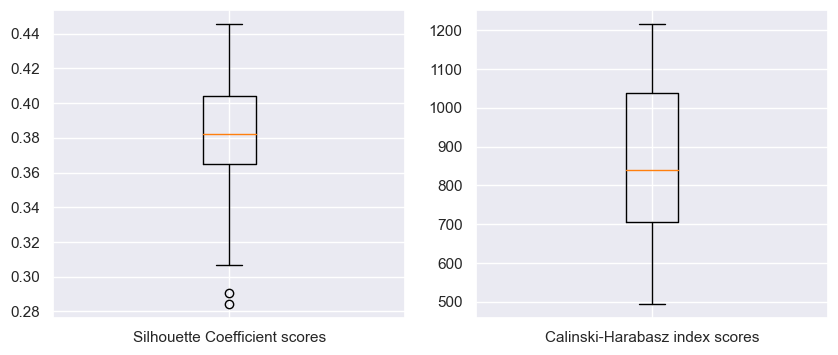

In [6]:
fig = plt.figure(figsize=(10, 4))
ax1, ax2 = fig.subplots(1, 2)
ax1.boxplot(results['silhouette'], labels=['Silhouette Coefficient scores'])
ax2.boxplot(results['calinski'], labels=['Calinski-Harabasz index scores'])

In [7]:
results.shape

(32, 6)

In [8]:
best_results = results.loc[(results['silhouette'] > 0.4) & (results['calinski'] > 1100)].sort_values(by='silhouette', ascending=False)
print(best_results)


               name  nfeat  clusters      inertia  silhouette     calinski
9         with DewP      4         3  2195.095215    0.445651  1211.845973
16  with Press DewP      5         2  3983.872070    0.421590  1216.290362
17  with Press DewP      5         3  2838.079102    0.417778  1147.390312
10        with DewP      4         4  1785.937988    0.410186  1103.546187


C:\Users\abhis\AppData\Local\Temp\ipykernel_22480\1375452551.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_22480\1375452551.py:70: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_22480\1375452551.py:67: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_22480\1375452551.py:70: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(18)
C:\Users\abhis\AppData\Local\Temp\ipykernel_22480\1375452551.py:67: 

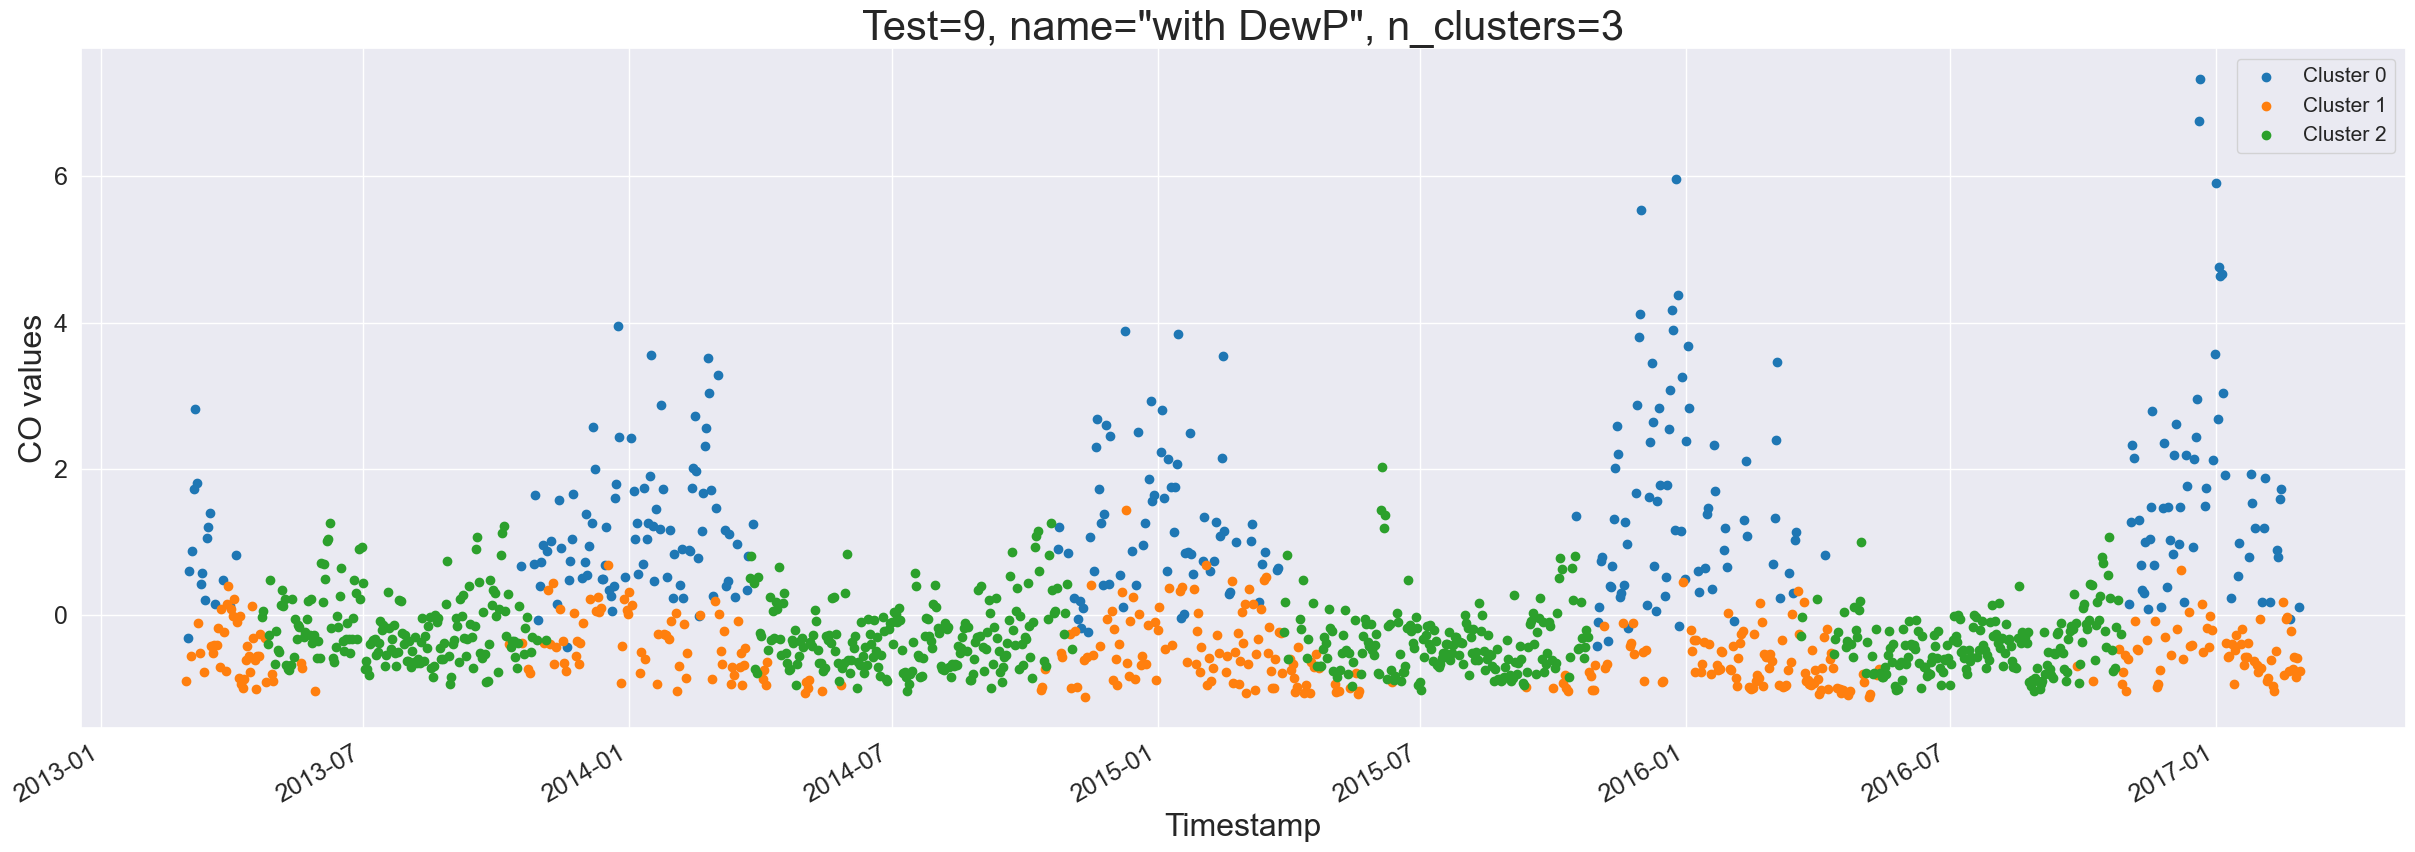

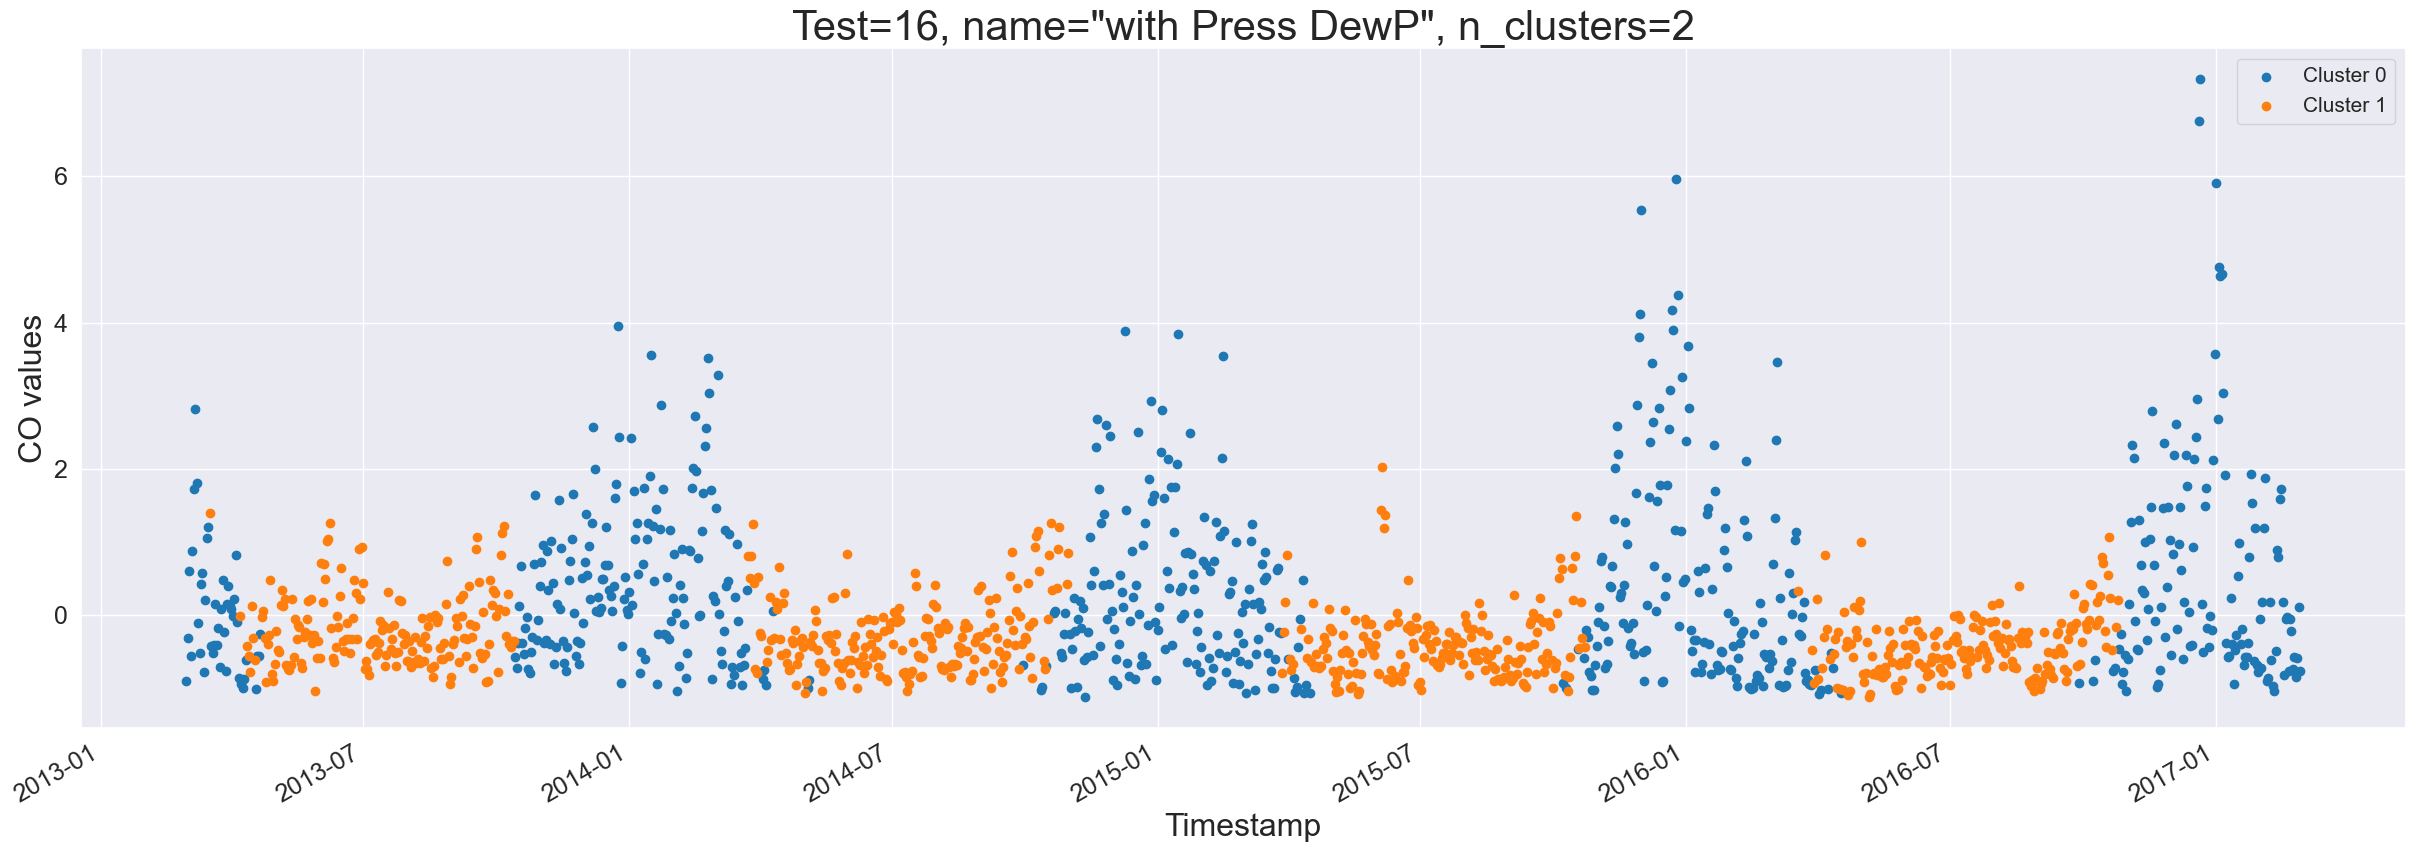

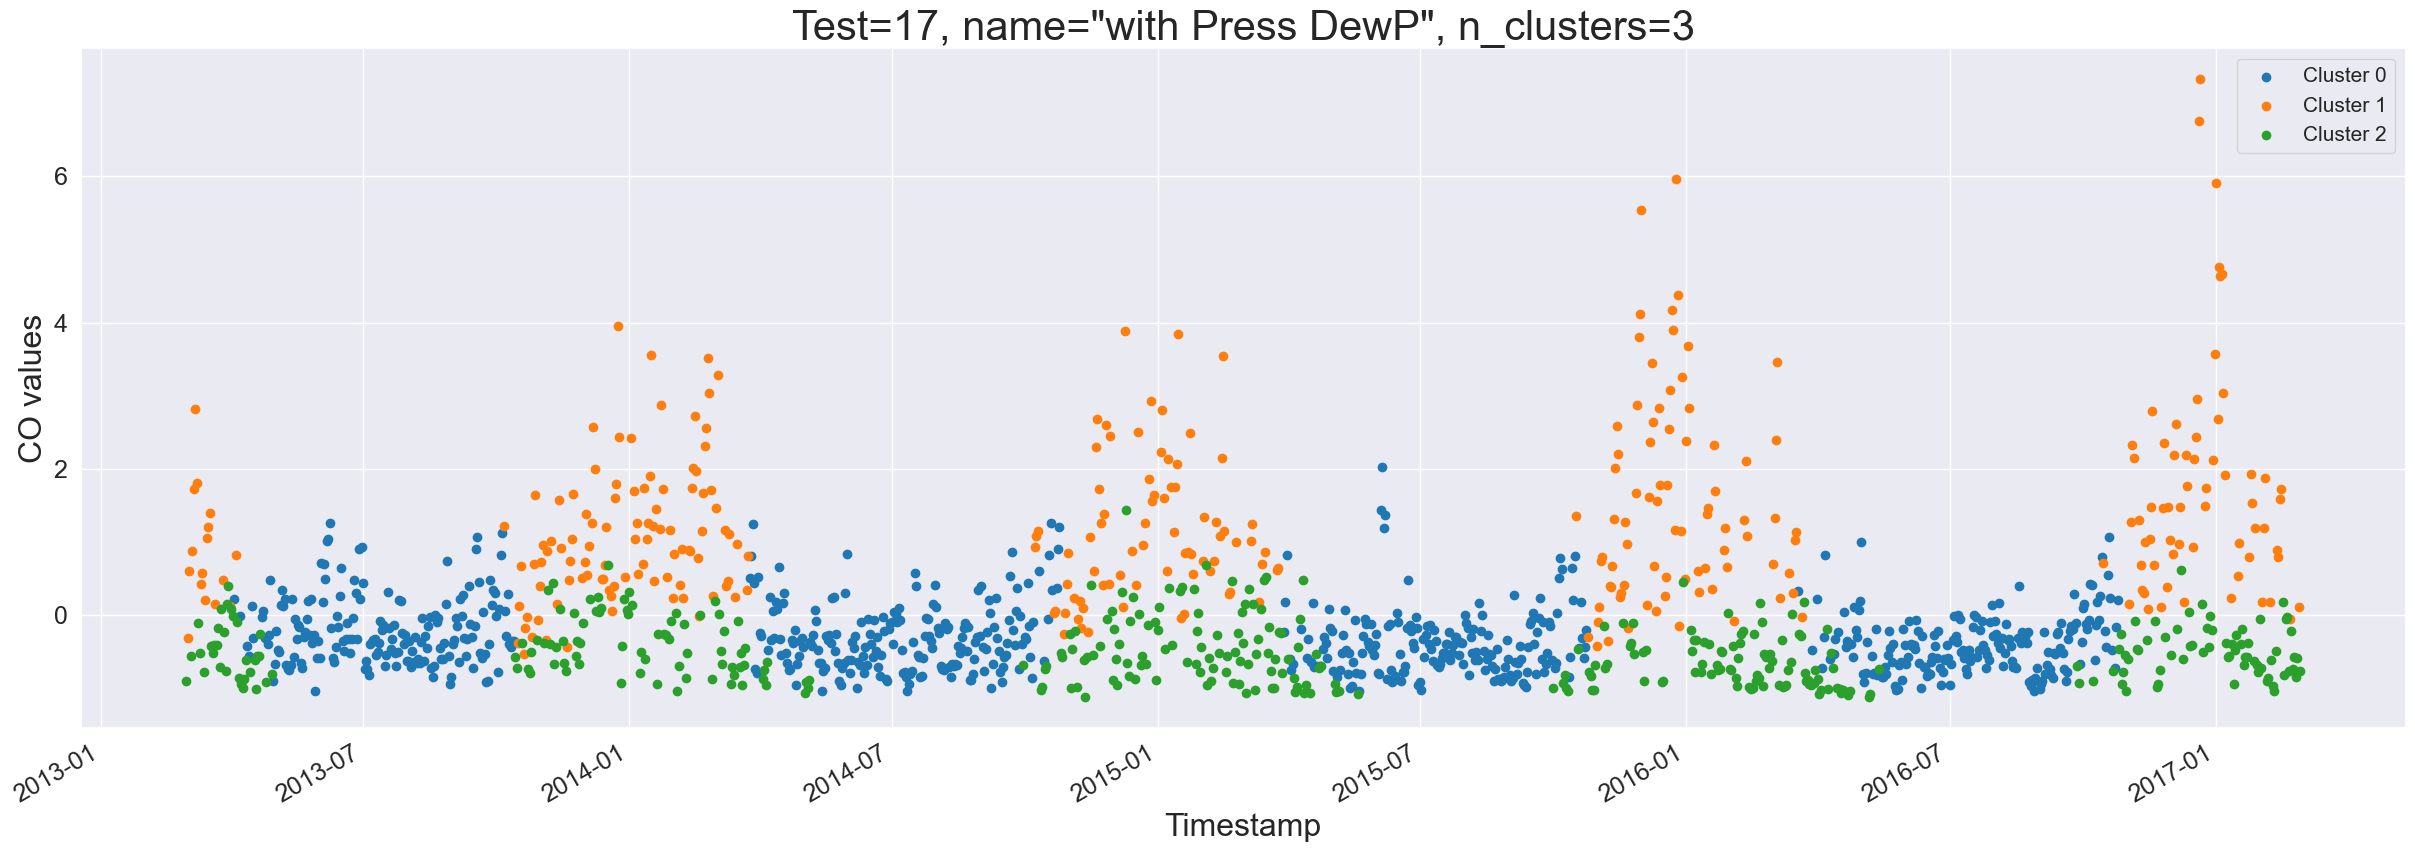

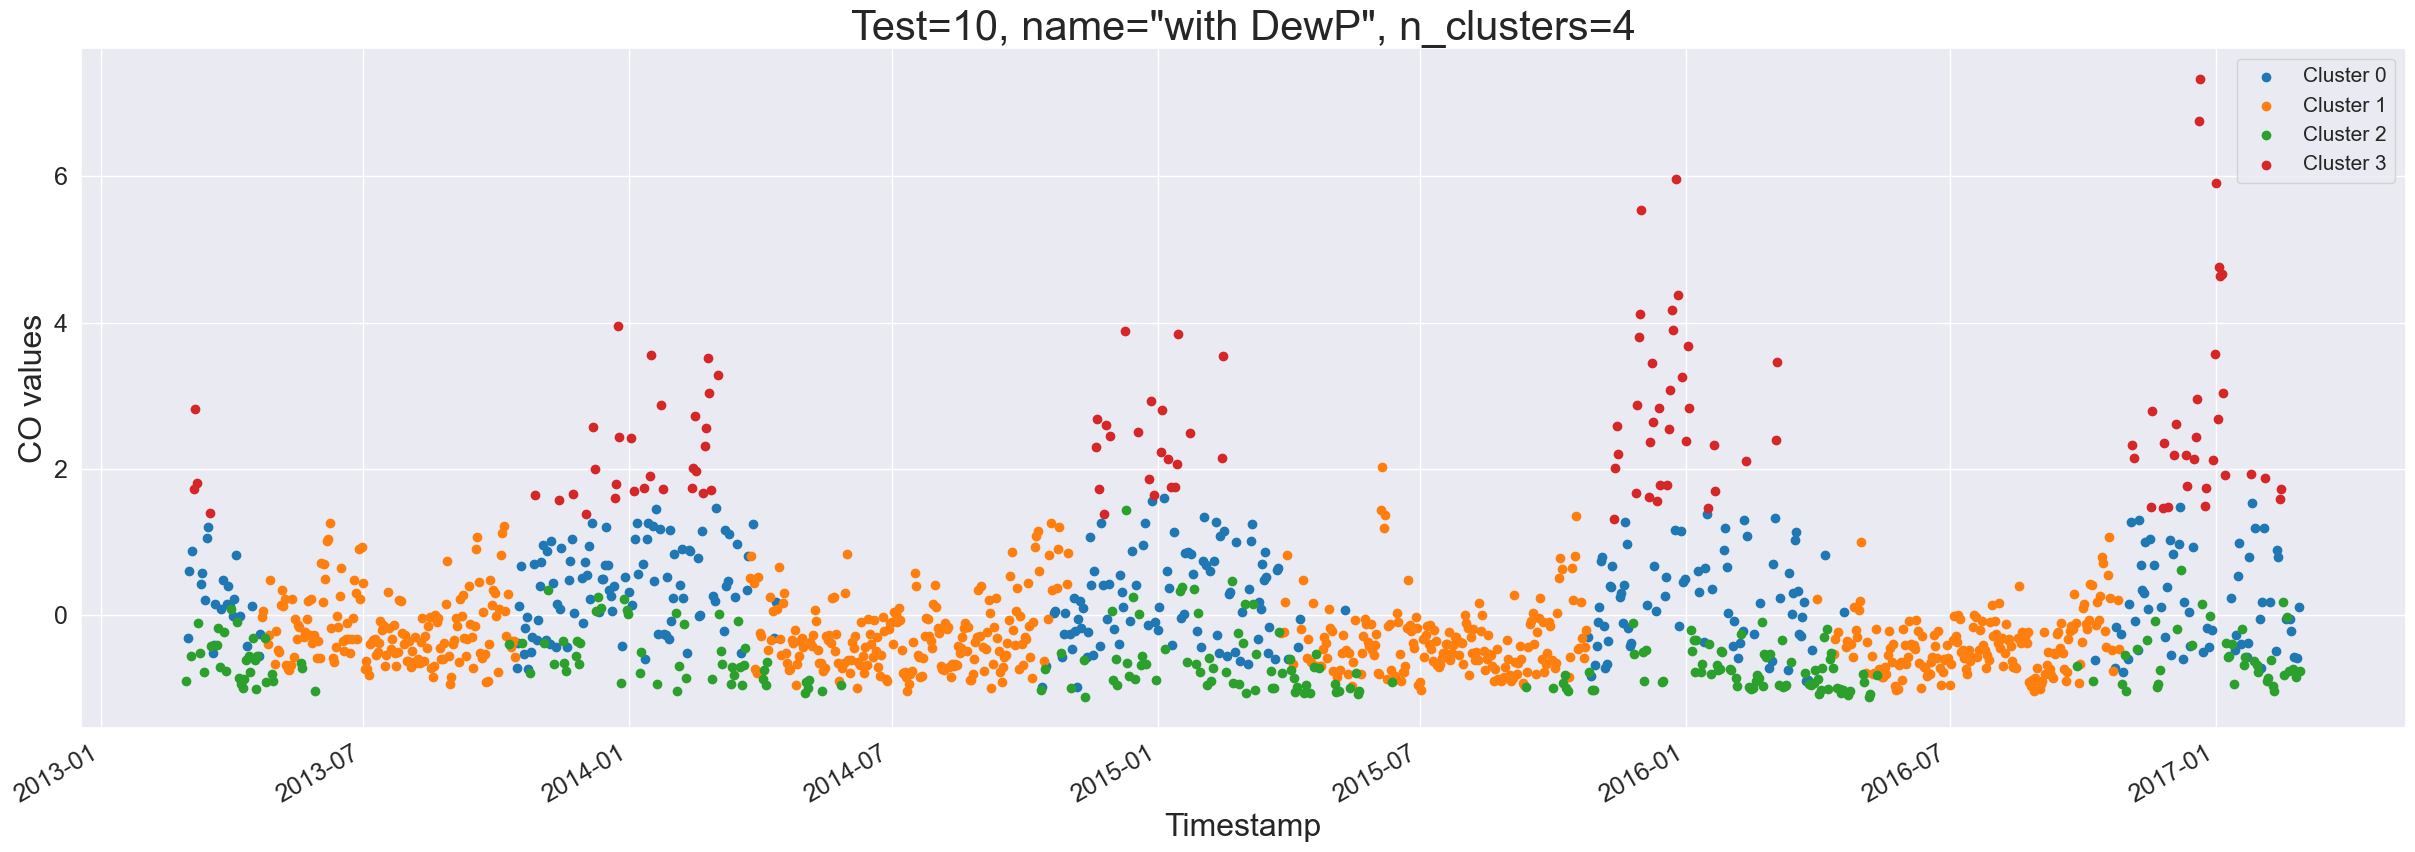

In [9]:
# Ploting clusters over the time series of the best models
for i in best_results.index:
    plot_ts_clusters_scatter(data_list[i], 'Test={}, name="{}", n_clusters={}'
                             .format(i, results.iloc[i, 0], results.iloc[i, 2]))